In [1]:
import syft as sy 

In [135]:
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [137]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 9b55730837544e9cb9b69e1a9edb26b5>,[Iris-data],,<class 'torch.Tensor'>
1,<UID: 3e17324701d74475a05709e7402edcfb>,[Iris-target],,<class 'torch.Tensor'>


In [138]:
data_pointer = duet.store[0]
target_pointer = duet.store[1]

In [139]:
duet.store.pandas["Tags"]

0      [Iris-data]
1    [Iris-target]
Name: Tags, dtype: object

creating the model with Torch 

In [140]:
in_dim = 4
out_dim = 3
N_exemple = 150

In [141]:
import torch

In [142]:
class SyNet(sy.Module):
    def __init__(self,torch_ref): 
        super(SyNet,self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim,30)
        self.layer2 = self.torch_ref.nn.Linear(30,40)
        self.out = self.torch_ref.nn.Linear(30,out_dim)
    def forward(self,x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x),dim=1)
        return output
        

In [143]:
model = SyNet(torch)

In [144]:
remote_model = model.send(duet)

we will create a remote torch called 'remote_torch' for our partner to differ it from the local torch named 'torch'

In [145]:
remote_torch = duet.torch

In [146]:
torch.__version__

'1.8.1+cpu'

know we will create pointer to the parameters of the remote_model and also for the adam optimize 

In [147]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params = params , lr=0.01 )



In [148]:
def train(iterations,model,torch_ref,optim,data_ptr,target_ptr): 
    losses = []
    for i in range(iterations):
        print("sssssss")
        optim.zero_grad()
        output  = model(data_ptr)
        loss = torch_ref.nn.functional.nll_loss(output,target_ptr.long())
        
        loss_item = loss.item()
        loss_value = loss_item.get(
            reason="to evaluate taraining progress",request_block=True,timeout_secs = 5)
        if i % 10 ==0: 
            print("Epoch ",i," loss ",loss_value)
        losses.append(loss_value)
        loss.backward()
        optim.step()
        print("fffff")
    return losses

In [149]:
iterations = 50
losses= train(iterations,remote_model,remote_torch,optim,data_pointer,target_pointer)

sssssss
Epoch  0  loss  None
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
Epoch  10  loss  None
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
Epoch  20  loss  None
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
Epoch  30  loss  None
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
Epoch  40  loss  None
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff
sssssss
fffff


In [121]:
import matplotlib.pyplot as plt

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

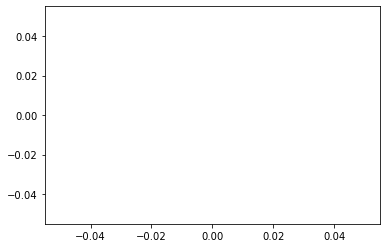

In [151]:
plt.plot(range(iterations),losses)

Download the model 

In [152]:
def get_model(model):
    if not model.is_local: 
        local_model = model.get(
                reason="To test the prediction on our data",request_block=True,timeout_secs=5
        )
    else:
        local_model = model
    return local_model

In [153]:
local_model = get_model(remote_model)

In [154]:
import torch 
import pandas as pd 
import numpy as np 
from sklearn.metrics import accuracy_score

In [155]:
x_test = pd.read_csv("archive/Iris.csv").drop("Species",axis=1)
y_test = pd.read_csv("archive/Iris.csv")["Species"]

In [156]:
y_test = pd.get_dummies(y_test)

In [157]:
x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.LongTensor(np.array(y_test))

In [158]:
x_test[0].unsqueeze(0)

tensor([[1.0000, 5.1000, 3.5000, 1.4000, 0.2000]])

In [159]:
preds = []
with torch.no_grad(): 
    for i in range(len(x_test)): 
        sample = x_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"prediction : {pred} GroundTruth : {y_test[i]}")
        preds.append(pred)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 4x30)